In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf

In [3]:
df1 = yf.download("^IXIC", start="2010-01-01", end="2023-04-30")
df2 = yf.download("^NSEI", start="2010-01-01", end="2023-04-30")
 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[0.943467591905385, 0.9439585841757134, 0.9444449257356793, 0.9449920822098853, 0.9455306106805285, 0.946063329562898, 0.9466095202451897, 0.9471446302076983, 0.9477096919386554, 0.9482362261854125, 0.948751310214809, 0.9492839758160373, 0.9497767429972326, 0.950286280116005, 0.9507737700328763, 0.9513138758576783, 0.9516503507715617, 0.95176397267261, 0.9518652512683698, 0.9519697336679616, 0.9520755817110503, 0.9521699858696248, 0.9522823272755723, 0.9523740066690727, 0.9524293216670959, 0.9524489370596473, 0.9524735208555906, 0.9525046891612214, 0.9525043391188185, 0.9524763924945745, 0.9524737996586068]


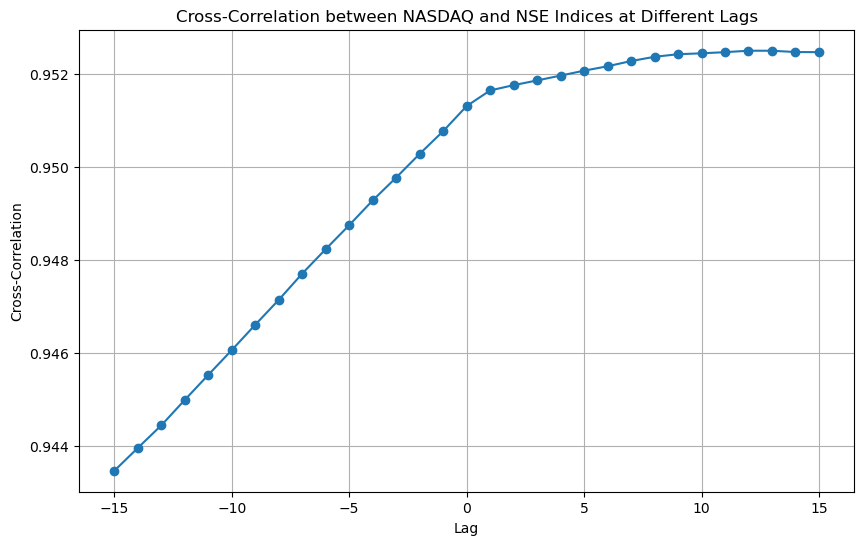

Best Lag: 12
NASDAQ leads NSE by 12 days.


In [4]:
nasdaq_close = df1['Close']
nse_close = df2['Close']

aligned_data = pd.merge(nasdaq_close, nse_close, on='Date', suffixes=('_nasdaq', '_nse'))
 
lags = range(-15, 16)  # Set the range of lags to consider
# cross_corr_values = [np.corrcoef(merged_data['Close_x'].shift(lag)[lag:], merged_data['Close_y'][lag:])[0,1] for lag in lags]
cross_corr_values = []
for lag in lags:
    if lag >= 0:
        cross_corr_values.append(np.corrcoef(aligned_data['Close_nasdaq'].shift(lag)[lag:], aligned_data['Close_nse'][lag:])[0,1])
    else:
        cross_corr_values.append(np.corrcoef(aligned_data['Close_nasdaq'].shift(lag)[:lag], aligned_data['Close_nse'][:lag])[0,1])

print(cross_corr_values)
# Plot the cross-correlation values against the lag periods
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr_values, marker='o', linestyle='-')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between NASDAQ and NSE Indices at Different Lags')
plt.grid(True)
plt.show()

# Find the lag with the highest cross-correlation value
best_lag = lags[np.argmax(cross_corr_values)]
print("Best Lag:", best_lag)

# Determine if NASDAQ leads or lags NSE based on the lag with the highest correlation
if best_lag > 0:
    print("NASDAQ leads NSE by", best_lag, "days.")
elif best_lag < 0:
    print("NSE leads NASDAQ by", abs(best_lag), "days.")
else:
    print("No consistent lead-lag relationship found.")


 

 




In [5]:
df1=df1[df1.High!=df1.Low]
df1.reset_index(inplace=True)
df1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,2308.419922,1931380000
1,2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2308.709961,2367860000
2,2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2301.090088,2253340000
3,2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2300.050049,2270050000
4,2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2317.169922,2145390000


In [6]:
df1['EMA_10']=ta.ema(df1.Close, length=10)
df1['EMA_9'] = ta.ema(df1.Close, lenght = 9)
df1['RSI']=ta.rsi(df1.Close, length=2)
df=ta.macd(df1.Close)
df1['MACD'] = df['MACD_12_26_9']
df1['MACD_signal'] = df['MACDs_12_26_9']
df1['MACD_histogram'] = df['MACDh_12_26_9']
 
my_bbands = ta.bbands(df1.Close, length=20, std=2.5)
 
df1=df1.join(my_bbands)
df1.dropna(inplace=True)
df1.reset_index(inplace=True)


def wwma(values, n):
    """
     J. Welles Wilder's EMA 
    """
    return values.ewm(alpha=1/n, min_periods=n,adjust=False).mean()

def atr(df, n):
    data = df.copy()
    high = data['High']
    low = data['Low']
    close = data['Close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

df1['Keltnar'] = atr(df1 ,10 )
df1['EMA+2*ATR'] = df1['EMA_10'] + 2*df1['Keltnar']

df1['EMA-2*ATR'] = df1['EMA_10'] - 2*df1['Keltnar']

df
t = 0
for i in range(11,3310):
    if(df['MACD_12_26_9'][i]>12 and df['MACDh_12_26_9'][i-1]>0  and df['MACDh_12_26_9'][i+1]<0):
        t =t+1
print(t) 

195


In [7]:
dfpl = df1[1000:1250].copy()

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.EMA_9, line=dict(color='orange', width=2), name="EMA"),
                go.Scatter(x=dfpl.index, y=dfpl['BBL_20_2.5'], line=dict(color='blue', width=1), name="BBL_20_2.5"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_20_2.5'], line=dict(color='blue', width=1), name="BBU_20_2.5"),
                
                ])
 
fig.show()

In [8]:
df1.dropna(axis=0, inplace=True)
 
 

MACD

In [9]:
ordersignal = [0]*len(df1)
buy = 2
sell = 1


for i in range(10,3318):
    if(df['MACD_12_26_9'][i]<12 and df['MACDh_12_26_9'][i-1]<0  and df['MACDh_12_26_9'][i+1]>0):
        ordersignal[i-10] = buy
    if(df['MACD_12_26_9'][i]>10 and df['MACDh_12_26_9'][i-1]>0  and df['MACDh_12_26_9'][i+1]<0):
        ordersignal[i-10] = sell   

df1['ordersignal'] = ordersignal


df1

        
    




,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_9,...,MACD_histogram,BBL_20_2.5,BBM_20_2.5,BBU_20_2.5,BBB_20_2.5,BBP_20_2.5,Keltnar,EMA+2*ATR,EMA-2*ATR,ordersignal
9,42,2010-03-05,2304.010010,2327.030029,2301.100098,2326.350098,2326.350098,2411880000,2269.021347,2269.021347,...,16.959789,2089.891558,2223.523022,2357.154487,12.019796,0.884741,22.752548,2314.526443,2223.516251,0
10,43,2010-03-08,2326.250000,2335.429932,2326.110107,2332.209961,2332.209961,2312310000,2280.510186,2280.510186,...,17.219007,2095.758971,2233.077515,2370.396059,12.298592,0.860958,21.409276,2323.328737,2237.691635,0
11,44,2010-03-09,2325.780029,2353.070068,2325.739990,2340.679932,2340.679932,2620360000,2291.450140,2291.450140,...,17.011303,2108.993711,2243.809009,2378.624307,12.016646,0.859273,22.001356,2335.452852,2247.447428,0
12,45,2010-03-10,2340.949951,2361.659912,2340.689941,2358.949951,2358.949951,2554740000,2303.722833,2303.722833,...,17.108474,2116.581853,2254.213000,2391.844148,12.211015,0.880499,21.899218,2347.521269,2259.924396,0
13,46,2010-03-11,2351.110107,2368.459961,2347.530029,2368.459961,2368.459961,2256790000,2315.493220,2315.493220,...,16.793603,2128.396286,2265.242493,2402.088700,12.082257,0.877129,21.802290,2359.097799,2271.888640,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,3348,2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,12076.936162,12076.936162,...,-20.547842,11727.054465,12051.002002,12374.949539,5.376276,0.478697,161.588130,12400.112423,11753.759901,0
3316,3349,2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,12026.431434,12026.431434,...,-39.459011,11736.499185,12052.518018,12368.536850,5.244030,0.099141,169.272384,12364.976201,11687.886666,0
3317,3350,2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,11995.143829,11995.143829,...,-46.720388,11782.900757,12059.431494,12335.962231,4.586132,0.129188,169.228153,12333.600136,11656.687523,0
3318,3351,2023-04-27,11972.150391,12154.009766,11950.919922,12142.240234,12142.240234,5253710000,12021.888630,12021.888630,...,-31.342315,11801.271593,12070.231494,12339.191396,4.456582,0.633865,182.271353,12386.431337,11657.345923,0


In [10]:
df1[df1.ordersignal!=0]

,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_9,...,MACD_histogram,BBL_20_2.5,BBM_20_2.5,BBU_20_2.5,BBB_20_2.5,BBP_20_2.5,Keltnar,EMA+2*ATR,EMA-2*ATR,ordersignal
57,90,2010-05-13,2416.360107,2434.290039,2387.590088,2394.360107,2394.360107,2375250000,2400.171989,2400.171989,...,-11.571706,2270.078914,2446.734497,2623.390080,14.440111,0.351761,63.376281,2526.924552,2273.419426,1
58,91,2010-05-14,2373.879883,2374.530029,2323.629883,2346.850098,2346.850098,2653020000,2390.477100,2390.477100,...,-12.094719,2256.519618,2440.014001,2623.508385,15.040437,0.246140,64.111676,2518.700451,2262.253748,1
76,109,2010-06-10,2188.709961,2219.649902,2185.979980,2218.709961,2218.709961,2187840000,2217.932231,2217.932231,...,-1.274655,2090.447978,2252.342517,2414.237057,14.375659,0.396128,60.229507,2338.391245,2097.473217,1
77,110,2010-06-11,2199.399902,2243.600098,2196.909912,2243.600098,2243.600098,1877120000,2222.599116,2222.599116,...,3.062472,2104.891040,2244.804517,2384.717993,12.465538,0.495696,58.875575,2340.350265,2104.847966,1
102,135,2010-07-19,2185.810059,2201.290039,2171.199951,2198.229980,2198.229980,1735090000,2200.739734,2200.739734,...,9.364492,2045.143706,2192.301501,2339.459297,13.424960,0.520143,44.286798,2289.313329,2112.166139,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,3287,2023-01-25,11146.530273,11334.219727,11069.179688,11313.360352,11313.360352,5485570000,11096.973778,11096.973778,...,82.224504,9882.102915,10783.921533,11685.740152,16.725244,0.793540,215.284840,11527.543458,10666.404098,1
3274,3307,2023-02-23,11636.929688,11638.980469,11432.580078,11590.400391,11590.400391,4714580000,11710.676336,11710.676336,...,-77.401228,11230.587685,11785.571533,12340.555381,9.418022,0.324165,225.293229,12161.262794,11260.089877,2
3275,3308,2023-02-24,11404.179688,11434.360352,11334.469727,11394.940430,11394.940430,4432650000,11653.269807,11653.269807,...,-89.484290,11203.365842,11779.698047,12356.030252,9.785178,0.166202,228.356973,12109.983753,11196.555862,2
3298,3331,2023-03-29,11855.589844,11941.599609,11823.349609,11926.240234,11926.240234,4493540000,11737.023426,11737.023426,...,32.251843,11080.007506,11601.913037,12123.818568,8.996887,0.810714,220.588773,12178.200972,11295.845880,1


BB BANDS


In [11]:
ordersignal = [0]*len(df1)
buy =2 
sell = 1

for i in range(9,3320):
    if((df1['Close'][i]-df1['BBL_20_2.5'][i])<0):
        ordersignal[i-9]= buy
    elif((df1['Close'][i]-df1['BBU_20_2.5'][i])>0):
        ordersignal[i-9] = sell
df1['BB_band_order'] = ordersignal
df1


,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_9,...,BBL_20_2.5,BBM_20_2.5,BBU_20_2.5,BBB_20_2.5,BBP_20_2.5,Keltnar,EMA+2*ATR,EMA-2*ATR,ordersignal,BB_band_order
9,42,2010-03-05,2304.010010,2327.030029,2301.100098,2326.350098,2326.350098,2411880000,2269.021347,2269.021347,...,2089.891558,2223.523022,2357.154487,12.019796,0.884741,22.752548,2314.526443,2223.516251,0,0
10,43,2010-03-08,2326.250000,2335.429932,2326.110107,2332.209961,2332.209961,2312310000,2280.510186,2280.510186,...,2095.758971,2233.077515,2370.396059,12.298592,0.860958,21.409276,2323.328737,2237.691635,0,0
11,44,2010-03-09,2325.780029,2353.070068,2325.739990,2340.679932,2340.679932,2620360000,2291.450140,2291.450140,...,2108.993711,2243.809009,2378.624307,12.016646,0.859273,22.001356,2335.452852,2247.447428,0,0
12,45,2010-03-10,2340.949951,2361.659912,2340.689941,2358.949951,2358.949951,2554740000,2303.722833,2303.722833,...,2116.581853,2254.213000,2391.844148,12.211015,0.880499,21.899218,2347.521269,2259.924396,0,0
13,46,2010-03-11,2351.110107,2368.459961,2347.530029,2368.459961,2368.459961,2256790000,2315.493220,2315.493220,...,2128.396286,2265.242493,2402.088700,12.082257,0.877129,21.802290,2359.097799,2271.888640,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,3348,2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,12076.936162,12076.936162,...,11727.054465,12051.002002,12374.949539,5.376276,0.478697,161.588130,12400.112423,11753.759901,0,0
3316,3349,2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,12026.431434,12026.431434,...,11736.499185,12052.518018,12368.536850,5.244030,0.099141,169.272384,12364.976201,11687.886666,0,0
3317,3350,2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,11995.143829,11995.143829,...,11782.900757,12059.431494,12335.962231,4.586132,0.129188,169.228153,12333.600136,11656.687523,0,0
3318,3351,2023-04-27,11972.150391,12154.009766,11950.919922,12142.240234,12142.240234,5253710000,12021.888630,12021.888630,...,11801.271593,12070.231494,12339.191396,4.456582,0.633865,182.271353,12386.431337,11657.345923,0,0


In [12]:
df1[df1.BB_band_order!=0]


,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_9,...,BBL_20_2.5,BBM_20_2.5,BBU_20_2.5,BBB_20_2.5,BBP_20_2.5,Keltnar,EMA+2*ATR,EMA-2*ATR,ordersignal,BB_band_order
36,69,2010-04-14,2481.800049,2504.860107,2480.429932,2504.860107,2504.860107,3143270000,2448.745209,2448.745209,...,2340.666406,2419.469507,2498.272608,6.514081,1.041797,25.131812,2499.008833,2398.481586,0,1
52,85,2010-05-06,2391.209961,2407.790039,2185.750000,2319.639893,2319.639893,4553600000,2438.048164,2438.048164,...,2354.535970,2474.907507,2595.279045,9.727356,-0.144952,57.923132,2553.894429,2322.201900,0,2
53,86,2010-05-07,2308.709961,2330.649902,2228.060059,2265.639893,2265.639893,4227720000,2406.701206,2406.701206,...,2299.704043,2465.487000,2631.269956,13.448293,-0.102737,62.389803,2531.480813,2281.921599,0,2
269,302,2011-03-16,2652.919922,2669.270020,2603.500000,2616.820068,2616.820068,2596000000,2705.792342,2705.792342,...,2616.926726,2750.273999,2883.621272,9.697017,-0.000400,46.403275,2798.598892,2612.985792,0,2
344,377,2011-07-01,2775.080078,2818.189941,2769.060059,2816.030029,2816.030029,1646380000,2726.172241,2726.172241,...,2558.377697,2683.576489,2808.775282,9.330741,1.028973,39.879817,2805.931875,2646.412606,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,2858,2021-05-12,13215.490234,13288.610352,13002.540039,13031.679688,13031.679688,4752930000,13550.757959,13550.757959,...,13103.649464,13811.096387,14518.543310,10.244616,-0.050866,243.567173,14037.892304,13063.623614,0,2
2893,2926,2021-08-18,14636.240234,14697.250000,14516.299805,14525.910156,14525.910156,3841840000,14724.093345,14724.093345,...,14543.488152,14760.929443,14978.370735,2.946173,-0.040420,150.878753,15025.850851,14422.335839,0,2
2915,2948,2021-09-20,14758.139648,14841.820312,14530.070312,14713.900391,14713.900391,4879490000,15064.218177,15064.218177,...,14733.429571,15143.909961,15554.390351,5.421062,-0.023788,190.214203,15444.646583,14683.789771,0,2
2966,2999,2021-12-01,15752.269531,15816.820312,15243.929688,15254.049805,15254.049805,6320260000,15654.934774,15654.934774,...,15320.958780,15806.106055,16291.253329,6.138732,-0.068957,276.761527,16208.457828,15101.411720,0,2


Keltner channels


In [13]:
ordersignal = [0]*len(df1)
buy =2 
sell = 1

for i in range(9,3320):
    if((df1['Close'][i]-df1['EMA-2*ATR'][i])<0):
        ordersignal[i-9]= buy
    elif((df1['Close'][i]-df1['EMA+2*ATR'][i])>0):
        ordersignal[i-9] = sell
df1['Keltner_order'] = ordersignal
df1

,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_9,...,BBM_20_2.5,BBU_20_2.5,BBB_20_2.5,BBP_20_2.5,Keltnar,EMA+2*ATR,EMA-2*ATR,ordersignal,BB_band_order,Keltner_order
9,42,2010-03-05,2304.010010,2327.030029,2301.100098,2326.350098,2326.350098,2411880000,2269.021347,2269.021347,...,2223.523022,2357.154487,12.019796,0.884741,22.752548,2314.526443,2223.516251,0,0,1
10,43,2010-03-08,2326.250000,2335.429932,2326.110107,2332.209961,2332.209961,2312310000,2280.510186,2280.510186,...,2233.077515,2370.396059,12.298592,0.860958,21.409276,2323.328737,2237.691635,0,0,1
11,44,2010-03-09,2325.780029,2353.070068,2325.739990,2340.679932,2340.679932,2620360000,2291.450140,2291.450140,...,2243.809009,2378.624307,12.016646,0.859273,22.001356,2335.452852,2247.447428,0,0,1
12,45,2010-03-10,2340.949951,2361.659912,2340.689941,2358.949951,2358.949951,2554740000,2303.722833,2303.722833,...,2254.213000,2391.844148,12.211015,0.880499,21.899218,2347.521269,2259.924396,0,0,1
13,46,2010-03-11,2351.110107,2368.459961,2347.530029,2368.459961,2368.459961,2256790000,2315.493220,2315.493220,...,2265.242493,2402.088700,12.082257,0.877129,21.802290,2359.097799,2271.888640,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3315,3348,2023-04-24,12053.469727,12103.580078,11960.299805,12037.200195,12037.200195,4854050000,12076.936162,12076.936162,...,12051.002002,12374.949539,5.376276,0.478697,161.588130,12400.112423,11753.759901,0,0,0
3316,3349,2023-04-25,11968.809570,11990.459961,11798.769531,11799.160156,11799.160156,4806020000,12026.431434,12026.431434,...,12052.518018,12368.536850,5.244030,0.099141,169.272384,12364.976201,11687.886666,0,0,0
3317,3350,2023-04-26,11913.230469,11967.990234,11833.070312,11854.349609,11854.349609,5281970000,11995.143829,11995.143829,...,12059.431494,12335.962231,4.586132,0.129188,169.228153,12333.600136,11656.687523,0,0,0
3318,3351,2023-04-27,11972.150391,12154.009766,11950.919922,12142.240234,12142.240234,5253710000,12021.888630,12021.888630,...,12070.231494,12339.191396,4.456582,0.633865,182.271353,12386.431337,11657.345923,0,0,0


In [14]:
df1[df1.Keltner_order!=0]

,index,Date,Open,High,Low,Close,Adj Close,Volume,EMA_10,EMA_9,...,BBM_20_2.5,BBU_20_2.5,BBB_20_2.5,BBP_20_2.5,Keltnar,EMA+2*ATR,EMA-2*ATR,ordersignal,BB_band_order,Keltner_order
9,42,2010-03-05,2304.010010,2327.030029,2301.100098,2326.350098,2326.350098,2411880000,2269.021347,2269.021347,...,2223.523022,2357.154487,12.019796,0.884741,22.752548,2314.526443,2223.516251,0,0,1
10,43,2010-03-08,2326.250000,2335.429932,2326.110107,2332.209961,2332.209961,2312310000,2280.510186,2280.510186,...,2233.077515,2370.396059,12.298592,0.860958,21.409276,2323.328737,2237.691635,0,0,1
11,44,2010-03-09,2325.780029,2353.070068,2325.739990,2340.679932,2340.679932,2620360000,2291.450140,2291.450140,...,2243.809009,2378.624307,12.016646,0.859273,22.001356,2335.452852,2247.447428,0,0,1
12,45,2010-03-10,2340.949951,2361.659912,2340.689941,2358.949951,2358.949951,2554740000,2303.722833,2303.722833,...,2254.213000,2391.844148,12.211015,0.880499,21.899218,2347.521269,2259.924396,0,0,1
13,46,2010-03-11,2351.110107,2368.459961,2347.530029,2368.459961,2368.459961,2256790000,2315.493220,2315.493220,...,2265.242493,2402.088700,12.082257,0.877129,21.802290,2359.097799,2271.888640,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,2981,2021-11-04,15849.740234,15966.089844,15827.660156,15940.309570,15940.309570,5297250000,15524.579901,15524.579901,...,15152.236377,16198.963821,13.816145,0.876446,166.707616,15857.995134,15191.164669,0,0,1
2949,2982,2021-11-05,16003.559570,16053.389648,15900.780273,15971.589844,15971.589844,5566400000,15605.854436,15605.854436,...,15221.838867,16304.733075,14.228165,0.846179,165.297792,15936.450021,15275.258852,0,0,1
3001,3034,2022-01-21,14046.219727,14171.719727,13764.240234,13768.919922,13768.919922,5870830000,14575.182880,14575.182880,...,15139.343896,16627.243663,19.656067,0.039477,336.823978,15248.830835,13901.534925,0,0,2
3099,3132,2022-06-13,10986.849609,11071.480469,10775.139648,10809.230469,10809.230469,5937320000,11657.417020,11657.417020,...,11727.332568,12692.352991,16.457629,0.024309,371.713212,12400.843444,10913.990596,0,0,2


In [15]:
buy_sell = df1[df1.ordersignal!=0].copy()
buy_sell.reset_index(inplace = True, drop = True)
m = len(buy_sell)

buy =0
profit = 0
transn = [0]*m
t = 0
amt = 0


for i in range(m):
    if(buy_sell['ordersignal'][i]==2):
        buy = buy + buy_sell['Close'][i]
        t = t+1
        amt = amt + buy_sell['Close'][i]
    elif(buy_sell['ordersignal'][i] ==1 and t!=0):
        profit = profit + (buy_sell['Close'][i]*t - buy)
        transn[i] = (buy_sell['Close'][i]*t - buy)/buy *100 
        buy = 0
        t = 0
    
print(profit)
print(amt)
print(transn)



9442.112060546875
897204.8395996094
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7.7725437614170545, 0, 0, 0, 2.412358328372851, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.7793299159608655, 0, 0, 0, -2.187491741943065, 0, 0, 0, 5.3602251320017436, 0, 0, 0, 0, 0, 0, 0, -0.11038920162499684, 0, 0, 0, 0, 0, 0, 8.30399528572791, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6.615845184110038, 0, 0, 0.3739593123836916, 0, 0, -2.9013693140549357, 0, 0, 0, 0, 0, 0, 0, 2.8294709899197383, 0, 2.095841885249632, 0, 0, 0, 0, 7.15679378192271, 0, 0, 0, 0, 0, 1.8927123278418252, 0, 0, 0, 3.3447525717839763, 0, 0, 0, 0, 0, 1.558289731128758, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.12411305308999768, 0, 0, 0, 2.1471132544986076, 0, 0, 0, 0, -2.595108397822646, 0, 0, 0, -2.9469534673609217, 0, 0, 0, 0, 0, 0, 0, 1.187479197700497, 0, 0, 0, 0, -0.055233920942824505, 0, 0, 0, 4.377299196581247, 0, 0, -1.3877707564255999, 0, 0, 0.02954254948608081, 0, 0, 0, 0, 0, 1.7282884722935958, 0, 0, 0, 0, 0, 0, 0, 0, 2.020856496541951, 0, 0, 0, 0, 0, 4.

In [16]:
buy_sell = df1[df1.BB_band_order!=0].copy()
buy_sell.reset_index(inplace = True, drop = True)
m = len(buy_sell)
buy =0
profit = 0
transn = [0]*m
t = 0
amt = 0


for i in range(m):
    if(buy_sell['BB_band_order'][i]==2):
        buy = buy + buy_sell['Close'][i]
        t = t+1
        amt = amt + buy_sell['Close'][i]
    elif(buy_sell['BB_band_order'][i] ==1 and t!=0):
        profit = profit + buy_sell['Close'][i]*t - buy
        transn[i] = (buy_sell['Close'][i]*t - buy)/buy *100
        
        buy = 0
        t = 0
    
print(profit)
print(amt)
print(transn)

54641.17626953125
281263.8312988281
[0, 0, 0, 0, 17.300374331338713, 0, 0, 0, 0, 0, 22.06823595241317, 0, 4.833816613514961, 0, 0, 0, 0, 0, 24.118226671503663, 0, 1.5212298531545863, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.398035064516025, 0, 0, 0, 0, 22.828543968850614, 0, 0, 7.7915356008215415, 0, 0, 0, 0, 10.039947386059463, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 52.68523517340934, 0, 0, 0, 0, 0, 0]


In [17]:
buy_sell = df1[df1.Keltner_order!=0].copy()
buy_sell.reset_index(inplace = True, drop = True)
m = len(buy_sell)
buy =0
profit = 0
transn = [0]*m
t = 0
amt = 0


for i in range(m):
    if(buy_sell['Keltner_order'][i]==2):
        buy = buy + buy_sell['Close'][i]
        t = t+1
        amt = amt + buy_sell['Close'][i]
    elif(buy_sell['Keltner_order'][i] ==1 and t!=0):
        profit = profit + buy_sell['Close'][i]*t - buy
        transn[i] = (buy_sell['Close'][i]*t - buy)/buy *100
        buy = 0
        t = 0
    
print(profit)
print(amt)
print(transn)

65158.721435546875
295130.30322265625
[0, 0, 0, 0, 0, 0, 0, 0, 0, 2.7562194024206836, 0, 6.51730888180854, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.584309472837925, 0, 0, 0, 11.301605750397764, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15.805335322106698, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21.869779154838177, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.237500121556069, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24.53300020580997, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 40.63058712099959, 0, 0, 0, 9.481920069571261, 0, 21.331865555991858, 0, 0, 0, 0, -0.7181572364872795]


In [18]:
a = df1['return'].to_numpy()
c = a-3.54
d = c.std()
b = np.average(a)

US_10_Year_Treasury = 3.54 

print('sharpe ratio =',(b-US_10_Year_Treasury)/d )

KeyError: 'return'